In [89]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [90]:
from PIL import Image
import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import requests
import scipy as sp
import tensorflow as tf
import tensorflow.keras as keras
import zipfile
import pathlib

import pandas as pd
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from datetime import datetime

In [91]:
os.environ['TF_CPP_MIN_LEVEL'] = '0'
np.set_printoptions(precision=3, suppress=True)
# stops the plt warnings
tf.get_logger().setLevel('ERROR')

In [92]:
# Opzet datum voor het opslaan van een bestand.
from datetime import datetime 
now = datetime.now()

# dd/mm/YY
time_save = now.strftime("%Hh%M")
dt_save = now.strftime("%d%m%Y")
# print("ddmmyyyy =", dt_save)
# print("HMS =", time_save)

# folder path to save model 
sp_model = r'saved_models/tf_tensor/model/'
sc_model = 0
# Iterate directory
for path in os.listdir(sp_model):
    # check if current path is a file
    if os.path.isfile(os.path.join(sp_model, path)):
        sc_model += 1
# print('File count:', sc_model)

In [93]:
# load dataset 

test_data_dir = '../data/Test'
train_data_dir = '../data/Train'


data_dir = pathlib.Path(train_data_dir)
test_dir = pathlib.Path(test_data_dir)
edgeFiles = list()
testFiles = list()

for filename in os.listdir(train_data_dir):
    imgAppleDirectory = os.path.join(train_data_dir, filename)
    edgeFiles.append(imgAppleDirectory)
    # print(edgeFiles)
    
for filename in os.listdir(test_data_dir):
    imgAppleTestDirectory = os.path.join(test_data_dir, filename)
    testFiles.append(imgAppleTestDirectory) 
    # print(testFiles)

In [94]:
edgeFiles = [img for img in edgeFiles if ".jpg" in img]
# print(type(edgeFiles))
# print(edgeFiles[0])

In [95]:
batch_size = 32
img_height = 224
img_width = 224

In [96]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 307 files for training.


In [97]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 383 files belonging to 4 classes.
Using 76 files for validation.


In [98]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  shuffle=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 120 files belonging to 4 classes.


In [99]:
class_names = train_ds.class_names
test_label = test_ds.class_names

In [100]:
# augmentation toegevoegen
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width,3)),
  layers.RandomRotation(25.5),
  layers.RandomZoom(0.6),  
])

In [101]:
# augmentation toegevoegen
image, label = next(iter(train_ds))

In [102]:
# augmentation toegevoegen
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

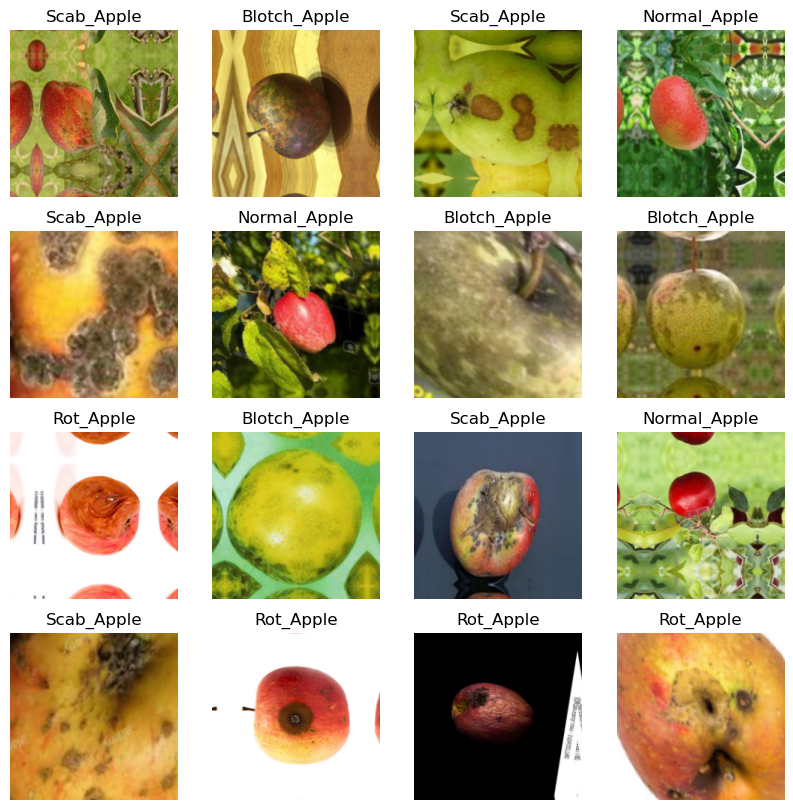

In [103]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        augmented_image = data_augmentation(images, training = True)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_image[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [104]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(rate=0.2 ),  
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(rate=0.2 ),  
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(16, activation='relu'),  
  layers.Dropout(rate=0.2 ),  
  layers.Flatten(),
  layers.Dense(num_classes)
])

In [105]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [106]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbackEarly = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [107]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [108]:
epochs=35
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard_callback]
)

Epoch 1/35
10/10 [==============================] - 17s 1s/step - loss: 1.3981 - accuracy: 0.2671 - val_loss: 1.3779 - val_accuracy: 0.2368
Epoch 2/35
10/10 [==============================] - 12s 1s/step - loss: 1.3641 - accuracy: 0.2801 - val_loss: 1.3541 - val_accuracy: 0.2368
Epoch 3/35
10/10 [==============================] - 10s 970ms/step - loss: 1.3562 - accuracy: 0.3713 - val_loss: 1.3327 - val_accuracy: 0.2763
Epoch 4/35
10/10 [==============================] - 10s 941ms/step - loss: 1.3088 - accuracy: 0.3616 - val_loss: 1.2831 - val_accuracy: 0.5263
Epoch 5/35
10/10 [==============================] - 11s 1s/step - loss: 1.2825 - accuracy: 0.4235 - val_loss: 1.2231 - val_accuracy: 0.4211
Epoch 6/35
10/10 [==============================] - 14s 1s/step - loss: 1.2774 - accuracy: 0.4137 - val_loss: 1.2606 - val_accuracy: 0.3289
Epoch 7/35
10/10 [==============================] - 15s 1s/step - loss: 1.2476 - accuracy: 0.4397 - val_loss: 1.1789 - val_accuracy: 0.4605
Epoch 8/35
10/

In [109]:
# Tensorboard
log_dir = "logs/fit" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [110]:
score = model.evaluate(test_ds)


4/4 [==============================] - 1s 205ms/step - loss: 1.0427 - accuracy: 0.5750


In [111]:
loss, accuracy = model.evaluate(train_ds)

10/10 [==============================] - 3s 207ms/step - loss: 0.7055 - accuracy: 0.7557


In [112]:
# folder path to save figureplot 
sp_model = r'saved_models/tf_tensor/model'
sc_model = 0
# Iterate directory
for path in os.listdir(sp_model):
    # check if current path is a file
    if os.path.isfile(os.path.join(sp_model, path)):
        sc_model += 1
print('File count:', sc_model)

File count: 5


In [113]:
from keras.models import load_model
model.save('saved_models/tf_tensor/model/tl_model_' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.h5')

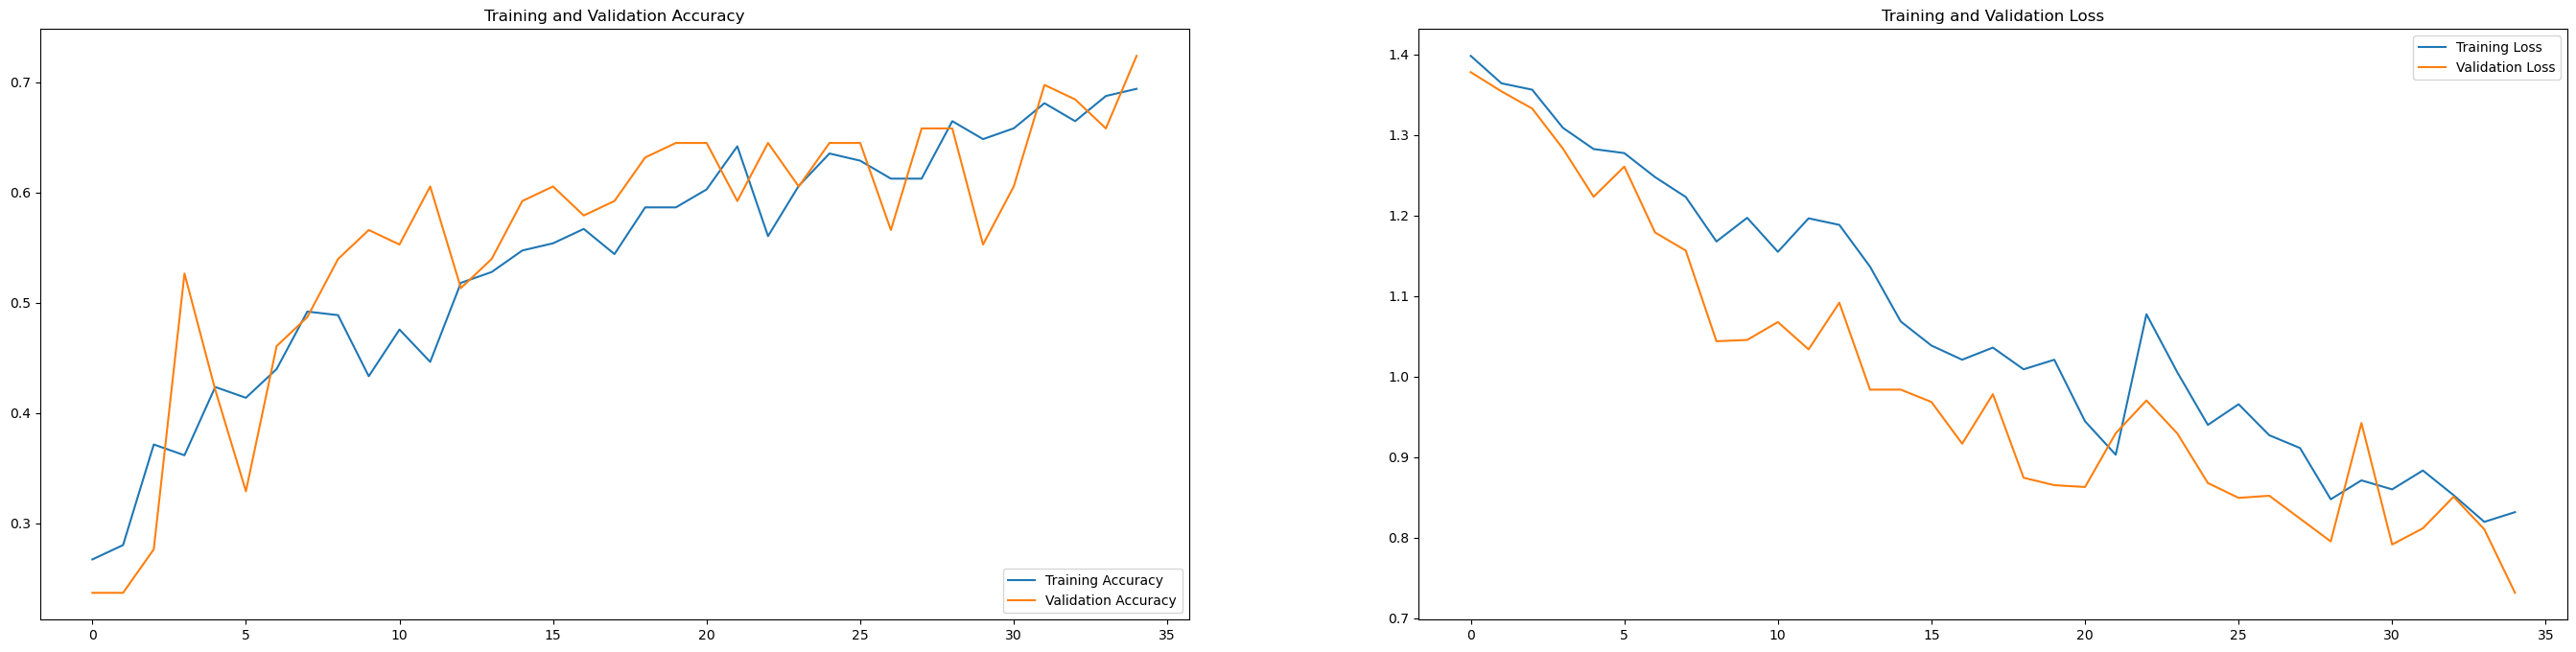

In [114]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(34, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('saved_models/tf_tensor/plt_fig/tl_fig' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.png')
plt.show()


4/4 [==============================] - 1s 201ms/step


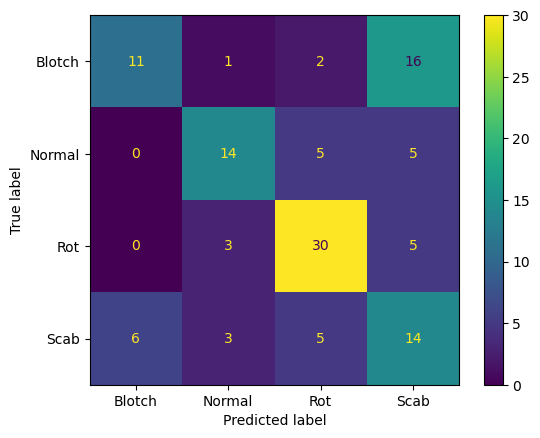

In [118]:
# confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

batchPredictions = model.predict(test_ds)
predicted_categories = tf.argmax(batchPredictions, axis=1)
true_categories = tf.concat([y for x, y in test_ds], axis=0)

# confusion_matrix(predicted_categories, true_categories)

confusion_matrix = confusion_matrix(true_categories, predicted_categories)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,display_labels = ['Blotch', 'Normal', 'Rot', 'Scab'])

cm_display.plot()
plt.savefig('saved_models/tf_tensor/plt_matrix/fig_matrix' + str(dt_save) + '_' + str(time_save) + '_' + str(sc_model) + '.png')
plt.show()


In [116]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

4/4 [==============================] - 1s 257ms/step - loss: 1.0427 - accuracy: 0.5750
Test accuracy : 0.574999988079071


In [117]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6007 (pid 31519), started 11:20:36 ago. (Use '!kill 31519' to kill it.)